In [1]:
#import libraries
import numpy as np
import matplotlib
from matplotlib import pyplot as plt 
import random

#local files being imported
import platform_opt
from players import *

In [2]:
'''Note: when indexed as a list: group $A$ is 0, group $B$ is 1.
      when indexed as a dict: group $A$ is -1, group $B$ is 1.'''

'Note: when indexed as a list: group $A$ is 0, group $B$ is 1.\n      when indexed as a dict: group $A$ is -1, group $B$ is 1.'

In [3]:
# SIMULATION PARAMETERS AGNOSTIC TO DATA
T = 15                 # max number of timesteps
M = 100000            # size of unit mass

In [4]:
# SIMULATION PARAMS DEPENDING ON DATASET
# parameters here come from probability_sharing_distributions.ipynb
pi = {1: 0.43294, 
     -1: 0.56706}          # number of members in groups a and b #estimated from probability_sharing_distributions.ipynb
pi_a = pi[-1]

# TODO: DOUBLE CHECK INDEXING IS CORRECT
# (alpha, beta) values for the beta distribution as a function of article and user groups.
# beta_dist indexed (article group, user group). 
beta_dist = {(-1,-1) : (41.45784070052453, 556.8653671739492),
            (1,-1) : (0.7519296311195025, 413.4664888783973),
            (-1,1) : (6.096475779403813, 1519.8459882514462),
            (1,1): (2152.960173995409, 23647.671142918956)}

# TODO: DOUBLE CHECK INDEXING IS CORRECT
# probability of like | click, user group, article group
# P indexed (article group, user group). expected values of above beta distribution
#estimated from probability_sharing_distributions.ipynb
P = {( -1,  -1):  0.0692, 
     ( 1, -1):  0.001815,
     (-1,  1):  0.003995,
     (1, 1):  0.08344} 

# TODO: DOUBLE CHECK INDEXING IS CORRECT
# player utility for liking, known to both user and platform,
# v indexed by (article group, user group) pair
#unclear what these values _should_ be!
v = {( 1,  1):   2000.,
     (-1,  1):   100.,
     ( 1, -1):   100.,
     (-1, -1):   2000. }

# TODO: DOUBLE CHECK INDEXING IS CORRECT
# cost of clicking, known to both user and platform,
# c indexed by (article shown, user group)
c = {( 1,  1):   1.,
     (-1,  1):   1.,
     ( 1, -1):   1.,
     (-1, -1):   1. }

# TODO: DOUBLE CHECK INDEXING IS CORRECT
# transition probability across groups at time t + 1 
# indexed by the first user's group membership
# seems too high to be practical
q = {-1:  0.9877, 
     1: 1.}

In [5]:
# SIMULATION PARAMS DEPENDING ON DATASET
# A = -1
# parameters here come from Replication Exposure.ipynb
pi = {1: 0.5, 
     -1: 0.5}          # number of members in groups a and b #estimated from probability_sharing_distributions.ipynb
pi_a = pi[-1]

# (alpha, beta) values for the beta distribution as a function of article and user groups.
# beta_dist indexed (article group, user group). 
beta_dist = {(1,1) : (0.9541492709534125, 1.345006644515015),
            (-1,1) : (0.1822515775580026, 2.7574965182522644),
            (1,-1) : (0.09576097403924465, 3.09136619146736),
            (-1,-1): (0.8828729918440646, 1.6247070146941363)}

# probability of like | click, user group, article group
# P indexed (article group, user group). expected values of above beta distribution
#estimated from probability_sharing_distributions.ipynb
P = {}
for a in [-1,1]:
    for g in [-1,1]:
        P[(a,g)] = beta_dist[(a,g)][0] / (beta_dist[(a,g)][0] +  beta_dist[(a,g)][1])


# player utility for liking, known to both user and platform,
# v indexed by (article group, user group) pair
#unclear what these values _should_ be!
v = {( 1,  1):   1000.,
     (-1,  1):   100.,
     ( 1, -1):   100.,
     (-1, -1):   1000. }

# cost of clicking, known to both user and platform,
# c indexed by (article shown, user group)
c = {( 1,  1):   1.,
     (-1,  1):   1.,
     ( 1, -1):   1.,
     (-1, -1):   1. }

# transition probability across groups at time t + 1 
# indexed by the first user's group membership
q = {-1: 0.7192525700416023, 
     1: 0.6797565445480234}

# approximation parameter for approximately equal probability
epsilon = 0.05  

In [6]:
#how to show articles at timestep 1
theta_hat = platform_opt.opt(pi, q, T, epsilon,c,v,beta_dist) #constrained with exposure equality
theta_tilde = platform_opt.opt_unconstrained(pi, q, T, epsilon,c,v,beta_dist) #unconstrained to optimize clicks

print(theta_hat)
print(theta_tilde)

{1: 1.0, -1: 0.0}
{1: 0.9999999999599892, -1: 4.3500351052646725e-11}


In [7]:
#runs the model given a strategy theta for showing articles at time step 1.
def runModel(theta, T, pi, M, p, beta_dist, v,c,q): 
    
    '''
    parameters:
    theta      :(dict) indexed by user group g; the proprtion of users in group g shown article A (1)
    T          :(int) max total number of timesteps
    pi         :(dict) indexed by user group; proportion of users in each group.  pi[1] = 1 - pi[-1]
    M          :(int) number of players in the mass
    p          :(dict) expected value for probably liking given a click given (article group, user group)
    beta_dist  :(dict) (alpha, beta) parameters for the beta distribution for above distribution.
    v          :(dict) value for liking an article. indexed (article group, user group)
    c          :(dict) cost for clicking on an article. indexed (article group, user group)
    q          :(dict) homophily variable.  probability of intra-group propogation at next timestep indexed by group
    
    returns:
    the number of clicked articles in the simulation.
    '''
    
    
    #tracking data; this could be way more efficient :face-palm:
    old_u = []
    time_data_diff = []
    num_players_in_model = [M]
    #prob_article_A = []
    #prob_article_A_cum = []
    tot_shown_A = 0
    tot_in_model = 0
    t = 1
    
    #dictionaries to keep track of who is shown which articles and who clicks on which articles
    #indexed (article, user)
    shown_dict = {(1,1):   0,
                  (-1,1):  0, 
                  (1,-1):  0,
                  (-1,-1): 0}
    
    click_dict = {(1,1):   0,
                  (-1,1):  0, 
                  (1,-1):  0,
                  (-1,-1): 0}
    
    share_dict = {(1,1):   0,
                  (-1,1):  0, 
                  (1,-1):  0,
                  (-1,-1): 0}
    


    while (t <= T) and (t == 1 or len(old_u) > 0):
        num_shown_A = 0 #number of players at this timestep that are shown article A
        new_u = []  # list of new players that arrive at the timestep

        if t == 1:  # initial mass of users arrives
            for i in range(M): # iterating over the size of the unit mass
                tot_in_model = tot_in_model + 1
                g = coin_toss(pi_a) # determine players group according to the true group distribution
                a = coin_toss(theta_hat[g]) # show article A according to the platform's policy.  (right now, this is just a placeholder)
                player = Player(group=g, article=a)
                shown_dict[(a,g)] = shown_dict[(a,g)] + 1
                if a == 1:
                    num_shown_A = num_shown_A + 1
                    player.article = 1
                else:
                    player.article = -1

                P_personal = P
                P_personal[(a,g)] = np.random.beta(*beta_dist[(a,g)])
                P_personal[(-a,g)] = np.random.beta(*beta_dist[(-a,g)])

                player.clicked = calcclickdict(player, 1, 
                                                  P_personal, 
                                                  q, 
                                                  theta_hat,
                                                  c,
                                                  v)
                if player.clicked:  
                    click_dict[(a,g)] = click_dict[(a,g)] + 1 
                    if random.uniform(0, 1) <= P[(player.article, player.group)]:
                        player.shared = True
                        share_dict[(a,g)] = share_dict[(a,g)] + 1
                old_u.append(player)
            #print("First time step: " + str(num_shown_A) + " users shown article A") #debugging statement

        else:
            for user in old_u:

                if user.shared == 1: # new user only added to the system if the previous user shared the article
                    tot_in_model = tot_in_model + 1
                    if random.uniform(0, 1) <= q[user.group]:  # if next person is drawn by homophily
                        new_user = Player(group=user.group)
                    else:
                        new_user = Player(group=-user.group)
                        
                    # show the previous person's article, regardless of the new user's group    
                    new_user.article = user.article
                    shown_dict[(new_user.article, new_user.group)] = shown_dict[(new_user.article, new_user.group)] + 1
                    if new_user.article == 1:
                        num_shown_A = num_shown_A + 1


                    P_personal = P
                    P_personal[(a,g)] = np.random.beta(*beta_dist[(new_user.article ,new_user.group)])
                    P_personal[(-a,g)] = np.random.beta(*beta_dist[(-a,g)])
                    new_user.clicked = calcclickdict(new_user, 1, 
                                                  P_personal, 
                                                  q, 
                                                  theta_hat,
                                                  c,
                                                  v)
                    # decide if user shares article, according to P.
                    if new_user.clicked == 1:  
                        click_dict[(new_user.article, new_user.group)] = click_dict[(new_user.article, new_user.group)] + 1
                        if random.uniform(0, 1) <= P[(new_user.article, new_user.group)]:
                            new_user.shared = True
                            share_dict[(new_user.article, new_user.group)] = share_dict[(new_user.article, new_user.group)] + 1
                    else:
                        new_user.shared = False

                    #add user to list
                    new_u.append(new_user)
                else: #only add a user to the next round if the previous user shared the article 
                    pass

            num_players_in_model.append(len(new_u)) #tracks how many players are being shown articles at all timesteps
            old_u = new_u



        t = t + 1
        tot_shown_A = tot_shown_A + num_shown_A
        #if len(old_u) > 0:
        #    prob_article_A.append(num_shown_A / float(len(old_u)))
        #    prob_article_A_cum.append(tot_shown_A / float(tot_in_model))

    #prop_shown_A_total = prob_article_A_cum[-1]
    
    return num_players_in_model, shown_dict, click_dict, share_dict


In [8]:
#run the model
players_in_model_fair, shown_d_fair, click_d_fair, share_d_fair = runModel(theta_hat, T, pi, M, P, beta_dist, v,c,q)
players_in_model_opt, shown_d_opt, click_d_opt, share_d_opt = runModel(theta_tilde, T, pi, M, P, beta_dist, v,c,q)

In [9]:
# price of fairness
clicks_opt = sum(players_in_model_opt[1:])
clicks_fair = sum(players_in_model_fair[1:])
pof = clicks_opt / clicks_fair
print('Price of fairness: ' + str(pof))

Price of fairness: 1.0023470378763353


In [10]:
# understanding equal exposure, and clicks, and shares
exposure_fair = {1 : shown_d_fair[(1,1)] +  shown_d_fair[(1,-1)], 
                 -1 :  shown_d_fair[(-1,1)] +  shown_d_fair[(-1,-1)]}#indexed by article 
clicks_fair =   {1 : click_d_fair[(1,1)] +  click_d_fair[(1,-1)], 
                 -1 :  click_d_fair[(-1,1)] +  click_d_fair[(-1,-1)]}#indexed by article 
share_fair =   {1 : share_d_fair[(1,1)] +  share_d_fair[(1,-1)], 
                 -1 :  share_d_fair[(-1,1)] +  share_d_fair[(-1,-1)]}#indexed by article 


exposure_opt = {1 : shown_d_opt[(1,1)] +  shown_d_opt[(1,-1)], 
                 -1 :  shown_d_opt[(-1,1)] +  shown_d_opt[(-1,-1)]}#indexed by article 
clicks_opt =   {1 : click_d_opt[(1,1)] +  click_d_opt[(1,-1)], 
                 -1 :  click_d_opt[(-1,1)] +  click_d_opt[(-1,-1)]}#indexed by article 
share_opt =   {1 : share_d_opt[(1,1)] +  share_d_opt[(1,-1)], 
                 -1 :  share_d_opt[(-1,1)] +  share_d_opt[(-1,-1)]}#indexed by article 


print(exposure_fair[1] / pi[1])
print(exposure_fair[-1] / pi[-1])

print(exposure_opt[1] / pi[1])
print(exposure_opt[-1] / pi[-1])

158824.0
140024.0
151116.0
147964.0


In [8]:
#no longer maintained... thoughts?  we can uncomment stuff if we still want this plot
plt.plot(prob_article_A, color='black')
plt.plot(prob_article_A_cum, color='red')
plt.title("Mass of articles being shown over time")
plt.ylabel("Proportion of users left being shown article $A$")
plt.xlabel("timestep $t$")
plt.axhline(y=pi_a,color='blue')
plt.ylim((-0.05,1.05))
plt.xlim((0,t))
plt.show()

NameError: name 'prob_article_A' is not defined

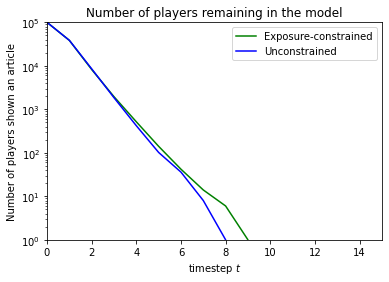

In [11]:
plt.plot(players_in_model_fair, color='green')
plt.plot(players_in_model_opt, color='blue')
plt.title("Number of players remaining in the model")
plt.ylabel("Number of players shown an article")
plt.xlabel("timestep $t$")
plt.yscale('log')
plt.xlim((0,T))
plt.ylim((1, M))
plt.legend(('Exposure-constrained', 'Unconstrained'))
plt.show()

In [12]:
#run the experiments multiple times for paper results
num_trials = 5

players_list_fair = []
shown_fair = []
click_fair = []
share_fair = []
players_list_opt = []
shown_opt = []
click_opt = []
share_opt = []


for i in range(num_trials):
    players_in_model_fair, shown_d_fair, click_d_fair, share_d_fair = runModel(theta_hat, T, pi, M, P, beta_dist, v,c,q)
    players_in_model_opt, shown_d_opt, click_d_opt, share_d_opt = runModel(theta_tilde, T, pi, M, P, beta_dist, v,c,q)
    
    players_list_fair.append(players_in_model_fair + ([0] * (T - len(players_in_model_fair))))
    shown_fair.append(shown_d_fair)
    click_fair.append(click_d_fair)
    share_fair.append(share_d_fair)
    
    players_list_opt.append(players_in_model_opt + ([0] * (T - len(players_in_model_opt))))
    shown_opt.append(shown_d_opt)
    click_opt.append(click_d_opt)
    share_opt.append(share_d_opt)
    

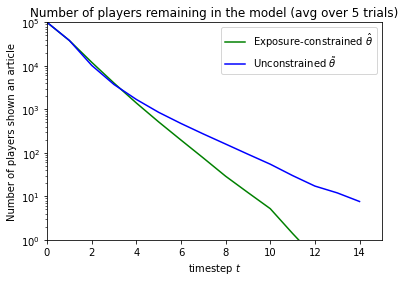

In [16]:
plt.plot(np.mean(players_list_fair, axis=0), color='green')
plt.plot(np.mean(players_list_opt, axis=0), color='blue')
plt.title("Number of players remaining in the model (avg over %i trials)" % (num_trials))
plt.ylabel("Number of players shown an article")
plt.xlabel("timestep $t$")
plt.yscale('log')
plt.xlim((0,T))
plt.ylim((1, M))
plt.legend(('Exposure-constrained $\hat \\theta$', 'Unconstrained $\\tilde \\theta$'))
plt.show()